In [1]:
# 필요한 모듈 import하기
from glob import glob
from pprint import pprint

import os
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

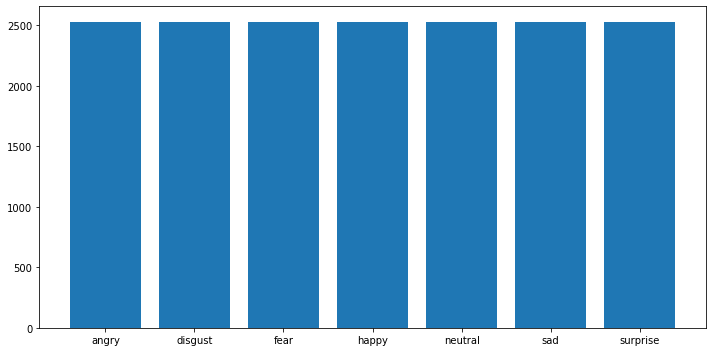

In [2]:
csv_path = './feelings_skfold2.csv'
df = pd.read_csv(csv_path)
np.unique(df['emotion'])

value_counts = df['emotion'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(range(len(value_counts)), value_counts.values)
plt.xticks(range(len(value_counts)), value_counts.index.values)
plt.tight_layout()
plt.show()

# **1. Model 정의하기**

* binary crossentropy : binary 다중 분류 손실 함수 -> label들이 독립적일 때 사용함
* categorical_crossentropy : 다중 분류 손실 함수, 출력값이 one-hot encoding된 결과로 나옴
* (정답에만 1으로 표시하고, 나머지는 0으로)
* 각 샘플이 정확히 하나의 클래스에 속하는 경우 사용한다.
* sparse_categorical_crossentropy : 다중 분류 손실 함수, one - hot - encoding을 하지 않고 정수 형태로 넣어줌, 한 샘플에 여러 클래스가 있거나 label이 soft 확률일 경우 사용

* softmax
- 출력은 0 ~ 1 사이의 실수
- 출력을 확률로 해석할 수 있음
- 출력의 총합은 1이다.

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import models

from tensorflow.keras.layers import Dense, Input, Flatten
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

def get_model(input_shape):
    no_of_classes = 7
    
    model = Sequential()
    
    #1st CNN layer
    model.add(Conv2D(64,(3,3),padding = 'same',input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))

    #2nd CNN layer
    model.add(Conv2D(128,(5,5),padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout (0.25))

    #3rd CNN layer
    model.add(Conv2D(512,(3,3),padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout (0.25))

    #4th CNN layer
    model.add(Conv2D(512,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    #Fully connected 1st layer
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))


    # Fully connected layer 2nd layer
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(no_of_classes, activation='softmax'))

    return model

In [5]:
input_shape = (48,48,1)    
model = get_model(input_shape)

adam = keras.optimizers.Adam(lr = 0.0001)

model.compile(
    optimizer = adam,
    loss = 'categorical_crossentropy', # one-hot encoding 형태로 label 전달
    metrics = ['accuracy']
)

model.summary()
plot_model(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

c:\users\doroc\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
import albumentations as A

# Albumentation class 생성하기
class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                # 수평 전환
                A.HorizontalFlip(p=0.5),
                # 이동, 크기, 회전을 설정
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                # 구멍을 dropout 하게됨(제대로 적용됨)
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8, # 최대 8개의 구멍을 dropout 시킴
                    max_height=int(0.1 * size[0]), # size = (48,48) -> 튜플 형태
                    max_width=int(0.1 * size[0])
                ),
                A.RandomBrightnessContrast(p=0.2) # 밝기 대비
            ])
    
    def __call__(self, **kwargs): # callback 함수: 클래스의 객체를 생성한 이후 객체를 호출할 떄 자동으로 실행되는 함수
        if self.transform:
            augmented = self.transform(**kwargs) # **kwargs : 가변 인수(파라미터의 개수에 제한을 두지 않겠다.)
            img = augmented['image'] # 증폭된 이미지
            return img 

In [8]:
csv_path = './feelings_skfold2.csv'

LABEL_INT_DICT = np.unique(pd.read_csv(csv_path)['emotion'])
pprint(LABEL_INT_DICT) # 데이터의 타입과 형태 등도 같이 보여준다.(조금 더 예쁘게 출력해준다?)
print("===================================")

LABEL_STR_DICT = {k:v for v,k in enumerate(LABEL_INT_DICT)}
pprint(LABEL_STR_DICT)

# 원-핫 인코딩의 형태로 emotion(label)의 형태 변경(딕셔너리의 key 변경)
# 원-핫 인토딩 어케 쓰는지 까먹어서...형태 걍 만들었습니다....^-^;
print("===================================")
LABEL_STR_DICT['angry'] = [1,0,0,0,0,0,0]
LABEL_STR_DICT['disgust'] = [0,1,0,0,0,0,0]
LABEL_STR_DICT['fear'] = [0,0,1,0,0,0,0]
LABEL_STR_DICT['happy'] = [0,0,0,1,0,0,0]
LABEL_STR_DICT['neutral'] = [0,0,0,0,1,0,0]
LABEL_STR_DICT['sad'] = [0,0,0,0,0,1,0]
LABEL_STR_DICT['surprise'] = [0,0,0,0,0,0,1]
pprint(LABEL_STR_DICT)

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)
{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}
{'angry': [1, 0, 0, 0, 0, 0, 0],
 'disgust': [0, 1, 0, 0, 0, 0, 0],
 'fear': [0, 0, 1, 0, 0, 0, 0],
 'happy': [0, 0, 0, 1, 0, 0, 0],
 'neutral': [0, 0, 0, 0, 1, 0, 0],
 'sad': [0, 0, 0, 0, 0, 1, 0],
 'surprise': [0, 0, 0, 0, 0, 0, 1]}


In [9]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
            
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle: # shuffle = True라면(df 앞의 인덱스를 지워주는 기능
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    # len()
    def __len__(self):
            return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            img_folder = r['emotion'] # type = np.str_

            image = cv2.imread(f'./datasets2\\{img_folder}\\{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, self.image_size)
            
            if self.mode == 'train':
                image = image.astype('uint8') # 정수로 형변환
                image = self.transform(image=image)

            image = image.astype('float32') # 실수로 다시 형변환         
            image = image / 255.

            
            emotion = str(img_folder)
            emotion = LABEL_STR_DICT[emotion]
            emotion = np.array(emotion,dtype = float)  # 원-핫 인코딩 적용 -> ndarray 형태로
            
            batch_x.append(image)
            batch_y.append(emotion)
        
        return batch_x, batch_y

In [10]:
csv_path = './feelings_skfold2.csv'

# batch_size, csv_path, fold, image_size, mode='train', shuffle=True

train_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = (48,48),
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1, 
    image_size = (48,48),
    mode = 'val',
    shuffle = True
)

In [11]:
# library import
from tensorflow.keras.optimizers import RMSprop,SGD,Adam # optimizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # 콜백함수

# Early-stopping 적용
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

# reduce_on_plateau
reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,reduce_on_plateau]

In [12]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 50,
    verbose = 1,
    callbacks = callbacks_list
)

Epoch 1/50
111/111 [==============================] - 228s 2s/step - loss: 2.2202 - accuracy: 0.1670 - val_loss: 1.9763 - val_accuracy: 0.1428 - lr: 1.0000e-04
Epoch 2/50
111/111 [==============================] - 265s 2s/step - loss: 2.0979 - accuracy: 0.1885 - val_loss: 1.9713 - val_accuracy: 0.1761 - lr: 1.0000e-04
Epoch 3/50
111/111 [==============================] - 237s 2s/step - loss: 2.0526 - accuracy: 0.2093 - val_loss: 1.9636 - val_accuracy: 0.1693 - lr: 1.0000e-04
Epoch 4/50
111/111 [==============================] - 244s 2s/step - loss: 2.0188 - accuracy: 0.2135 - val_loss: 1.9667 - val_accuracy: 0.1834 - lr: 1.0000e-04
Epoch 5/50
111/111 [==============================] - 230s 2s/step - loss: 1.9784 - accuracy: 0.2311 - val_loss: 1.8927 - val_accuracy: 0.2001 - lr: 1.0000e-04
Epoch 6/50
111/111 [==============================] - 239s 2s/step - loss: 1.9414 - accuracy: 0.2453 - val_loss: 1.8029 - val_accuracy: 0.2683 - lr: 1.0000e-04
Epoch 7/50
111/111 [====================

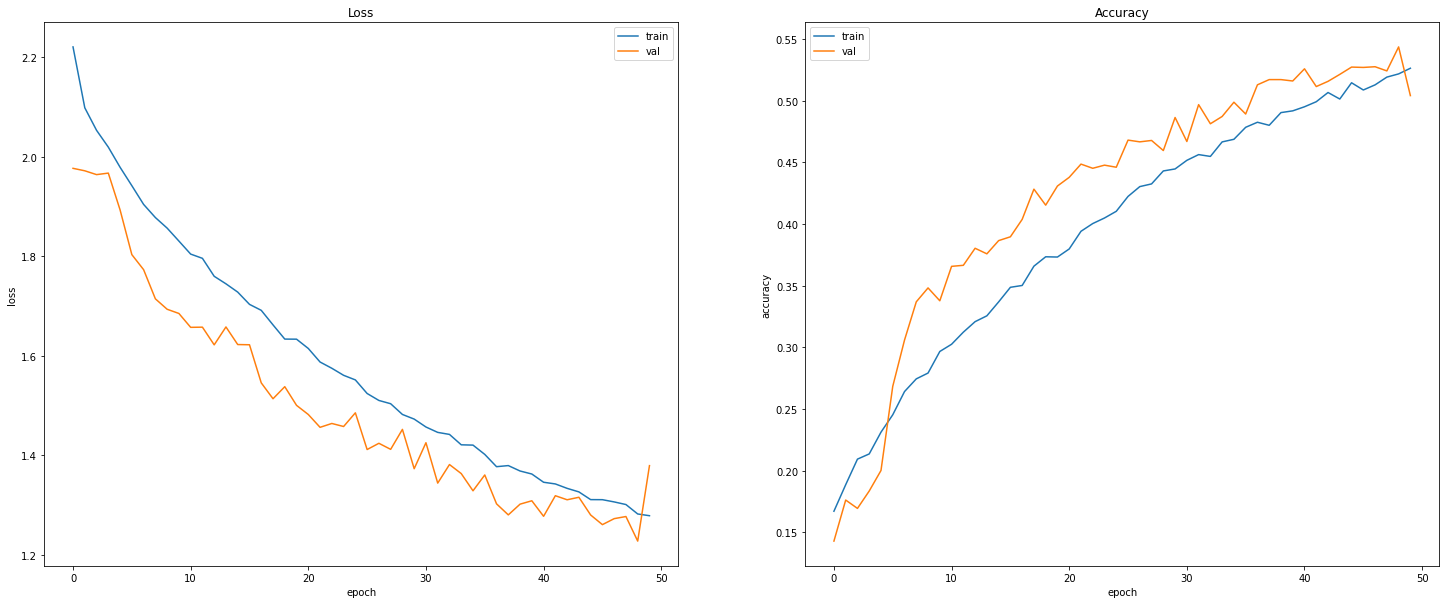

In [13]:
history = history.history

plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()

In [14]:
model.save('emotion_model.h5') # 모델 저장하기